# LCZ analysis for weather Stations of WRF/observations

In [17]:
import xarray as xr
from datatree import DataTree
import matplotlib.pyplot as plt
import os
import valenspy as vp
from valenspy._utilities import load_yml
from valenspy.processing.select import select_point
from valenspy.diagnostic.functions import mean_bias, mean_absolute_error, root_mean_square_error, spearman_correlation, perkins_skill_score, time_series_spatial_mean, calc_metrics_dt, calc_metrics_da,_add_ranks_metrics, root_mean_square_error
from valenspy.diagnostic.visualizations import plot_time_series, plot_map, plot_metric_ranking
from pathlib import Path
import pandas as pd
import numpy as np
import xoak
from sklearn.neighbors import BallTree as skBallTree
from scipy.stats import pearsonr

from functions import point_data_2_climate_grid, plot_points_map

# define machine name - used for paths of (observational) datasets
machine = 'hortense'

manager = vp.InputManager(machine=machine)

### Changeable variables

In [18]:
wrf_variable = "LU_INDEX"
obs_data_str = "wow"

## Settings

In [19]:
# define bounds 
bounds = {'europe':
                    {'lat_bounds': [70,35], 
                    'lon_bounds': [-15,40]}, 
        'belgium': 
                    {'lat_bounds': [52,49], 
                    'lon_bounds': [2,7]}}

In [20]:
ucl_dir = "/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/fiens/UCL/"
file_w2w = "D3_LCZ_map_WGS84.tif"
file_geo = "geo_em.d03_LCZ_params.nc"

ds = xr.open_mfdataset(ucl_dir + file_geo, combine='by_coords')
ds = ds.assign_coords({"lat":ds.CLAT})
ds = ds.assign_coords({"lon":ds.CLONG})
da = ds[wrf_variable]
da.xoak.set_index(['lat', 'lon'], 'sklearn_geo_balltree')

In [21]:
da

<xarray.DataArray 'LU_INDEX' (Time: 1, south_north: 252, west_east: 324)> Size: 327kB
dask.array<open_dataset-LU_INDEX, shape=(1, 252, 324), dtype=float32, chunksize=(1, 252, 324), chunktype=numpy.ndarray>
Coordinates:
    lat      (Time, south_north, west_east) float32 327kB dask.array<chunksize=(1, 252, 324), meta=np.ndarray>
    lon      (Time, south_north, west_east) float32 327kB dask.array<chunksize=(1, 252, 324), meta=np.ndarray>
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    units:        category
    description:  Dominant category
    stagger:      M
    sr_x:         1
    sr_y:         1

In [22]:
d_coord_points = pd.read_csv(ucl_dir + "Locations_" + obs_data_str + "_sensor.csv")
d_coord_points = d_coord_points.reset_index(drop = True)
d_coord_points

,code,lat,lon
0,16832,49.731007,6.510620
1,18074,49.808070,5.761474
2,23599,49.949005,6.018646
3,30652,50.198620,4.987458
4,35136,50.354847,4.265076
...,...,...,...
193,80288,51.535828,6.068695
194,80884,51.590530,5.316010
195,81223,51.589480,5.535034
196,81227,51.586727,5.593170


### Extracting value of variable at locations

In [23]:
df_point_var = d_coord_points.copy()
for i in np.arange(0, len(d_coord_points)):
        point_coord = d_coord_points.loc[i]

        lat_array = xr.DataArray(np.array([point_coord.lat]), dims='point')
        lon_array = xr.DataArray(np.array([point_coord.lon]), dims='point')

        da_temp = da.xoak.sel(lat = lat_array, lon = lon_array)
        df_point_var.loc[i, wrf_variable] = da_temp.to_pandas().values


In [24]:
df_point_var

,code,lat,lon,LU_INDEX
0,16832,49.731007,6.510620,14.0
1,18074,49.808070,5.761474,14.0
2,23599,49.949005,6.018646,5.0
3,30652,50.198620,4.987458,5.0
4,35136,50.354847,4.265076,12.0
...,...,...,...,...
193,80288,51.535828,6.068695,56.0
194,80884,51.590530,5.316010,56.0
195,81223,51.589480,5.535034,14.0
196,81227,51.586727,5.593170,14.0


<Axes: xlabel='LU_INDEX', ylabel='count'>

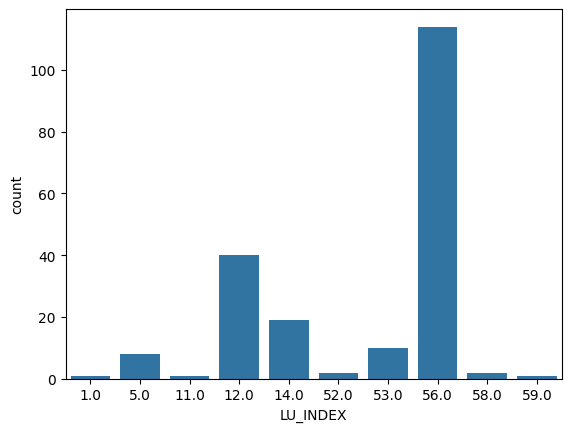

In [25]:
import seaborn as sns
sns.countplot(data = df_point_var, x = "LU_INDEX")

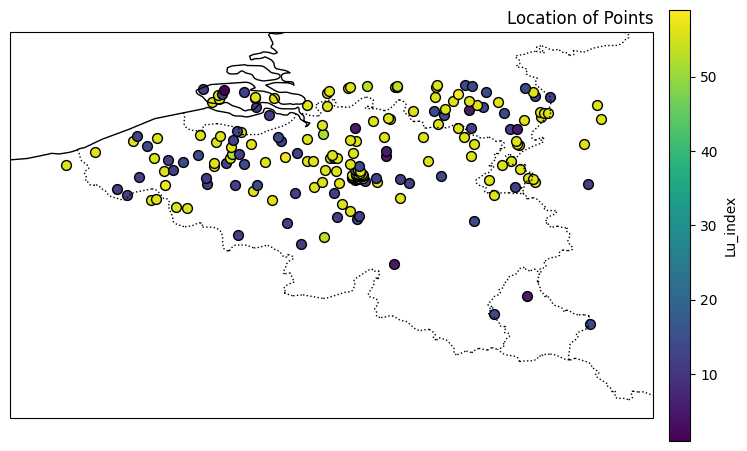

In [26]:
ax = plot_points_map(df_point_var, "belgium", bounds, scale_var = wrf_variable, station_id = wrf_variable)

In [32]:
if obs_data_str == "wow":
    df_urban = df_point_var.loc[np.where(df_point_var.LU_INDEX >= 50)[0]].reset_index(drop = True)
    df_rural = df_point_var.loc[np.where(df_point_var.LU_INDEX < 50)[0]].reset_index(drop = True)
    df_rural.to_csv(ucl_dir + 'Location_rural_' + obs_data_str + ".csv", index = False)
    df_urban.to_csv(ucl_dir + 'Location_urban_' + obs_data_str + ".csv", index = False)

<Axes: xlabel='LU_INDEX', ylabel='count'>

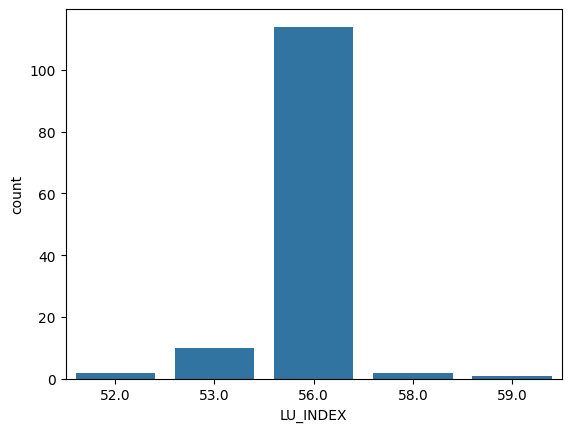

In [31]:
import seaborn as sns
sns.countplot(data = df_urban, x = "LU_INDEX")